In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Read data

In [253]:
# Read data
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')

# Semiconductor ETF price
etf_price = pd.read_csv('../data/processed/etf_price.csv')

In [254]:
etf_price

,Period,etf_price
0,2010-01-01,12.225553
1,2010-02-01,13.201204
2,2010-03-01,14.057395
3,2010-04-01,14.341842
4,2010-05-01,13.403166
...,...,...
166,2023-11-01,170.488037
167,2023-12-01,191.216141
168,2024-01-01,194.902161
169,2024-02-01,216.865021


In [255]:
# Merge
data = pd.merge(uncertainty,etf_price,on='Period')

# Set 'period' as the index
data.set_index('Period', inplace=True)

# Create a new column 'y_diff' representing the difference (lagged by 1 period) of ip
data['etf_price_diff'] = data['etf_price'].diff()
data.dropna(inplace=True)

# Create a new column 'etf_price_diff_abs' representing the absolute value of the difference
data['etf_price_diff_abs'] = data['etf_price_diff'].abs()


In [256]:
data

,uncertainty,etf_price,etf_price_diff,etf_price_diff_abs
Period,,,,
2010-02-01,0.153836,13.201204,0.975651,0.975651
2010-03-01,0.254106,14.057395,0.856191,0.856191
2010-04-01,0.169631,14.341842,0.284447,0.284447
2010-05-01,0.358944,13.403166,-0.938676,0.938676
2010-06-01,0.116282,12.433201,-0.969965,0.969965
...,...,...,...,...
2022-12-01,1.438426,114.326065,-13.158127,13.158127
2023-01-01,3.734089,132.996445,18.670380,18.670380
2023-02-01,1.108370,135.022644,2.026199,2.026199


### STNSU & ETF

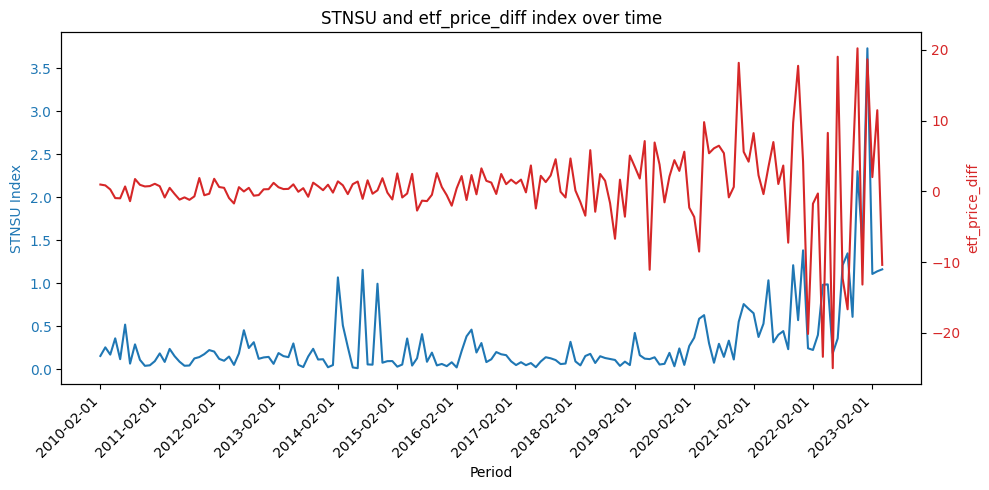

In [257]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first time series on the left y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('STNSU Index', color=color)
ax1.plot(data.index, data['uncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('etf_price_diff', color=color)
ax2.plot(data.index, data['etf_price_diff'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
ax1.set_xticks(data.index[::12])
ax1.set_xticklabels(data.index[::12], rotation=45, ha='right')

# Show the plot
plt.title('STNSU and etf_price_diff index over time')
plt.tight_layout() 
plt.show()


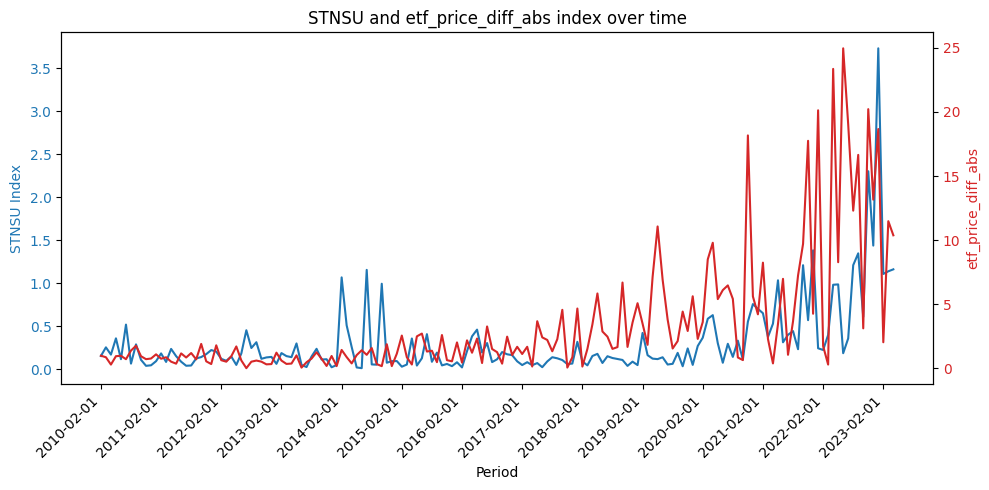

In [258]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first time series on the left y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('STNSU Index', color=color)
ax1.plot(data.index, data['uncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('etf_price_diff_abs', color=color)
ax2.plot(data.index, data['etf_price_diff_abs'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
ax1.set_xticks(data.index[::12])
ax1.set_xticklabels(data.index[::12], rotation=45, ha='right')

# Show the plot
plt.title('STNSU and etf_price_diff_abs index over time')
plt.tight_layout() 
plt.show()


### Model


In [259]:
# Set target and feature data
Y = data['etf_price_diff']
X = data['uncertainty']


In [260]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(X, Y)
print(f"Correlation: {correlation}, p-value: {p_value}")

# Positive Correlation: The correlation coefficient is significantly positive, X and Y move together in the same direction.

Correlation: 0.193905633587593, p-value: 0.014323130061531809


Granger Causality Tests: only for stationary time series--- cannot use this

In [261]:
# from statsmodels.tsa.stattools import grangercausalitytests
# 
# # Prepare data
# data_for_test = data[['etf_price_diff_abs', 'uncertainty']].dropna()
# 
# # Perform Granger Causality Test
# max_lag = 1
# gc_test = grangercausalitytests(data_for_test, max_lag, verbose=True)
# 
# # The output will provide F-statistics and p-values for each lag.
# # confirms that X has predictive power over Y


ADL model
https://www.econometrics-with-r.org/14.5-apatadlm.html
optional: add shade for specific period

In [262]:
def lag_list(Y, X, p, q):

    ADLx = pd.DataFrame()
    T = len(Y)
    ADLy = list(Y[max(p, q):T])
    for i in range(1, p+1):
        name = f'y_{i}'
        ADLx[name] = list(Y[max(p, q)-i:T-i])
    for i in range(1, q+1):
        name = f'x_{i}'
        ADLx[name] = list(X[max(p, q)-i:T-i])
        
    return ADLy, ADLx
    

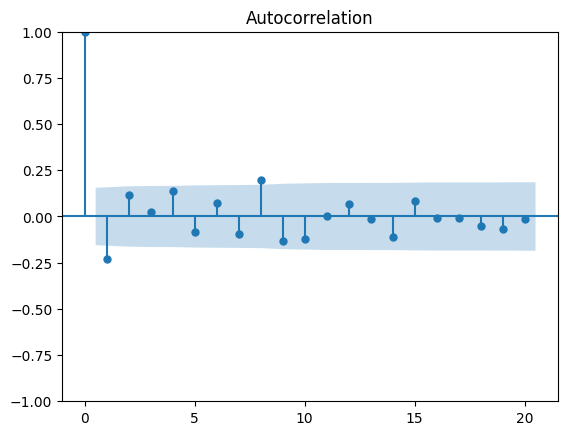

In [267]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(Y, lags=20)
plt.show()  # for p: p = 4

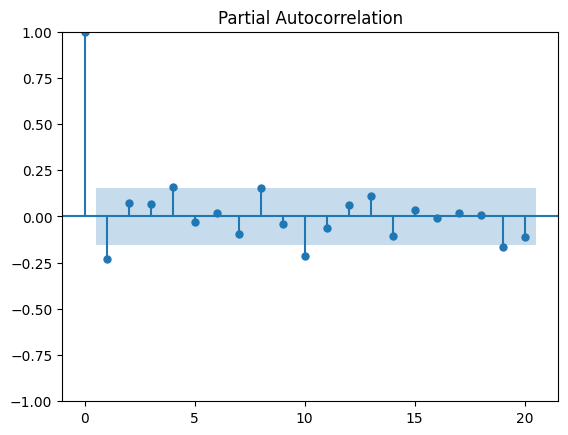

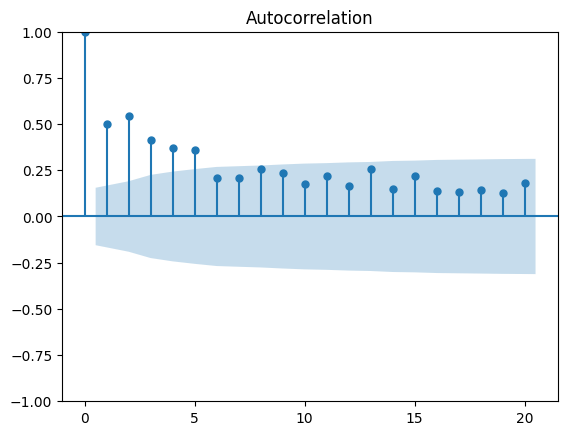

In [263]:


plot_pacf(Y, lags=20)
plt.show()  # for p: p = 4

plot_acf(X, lags=20)
plt.show() # for q: q=2


In [266]:
# Model 
ADLy1, ADLx1 = lag_list(Y, X, p=1, q=2)
ADLx1 = sm.add_constant(ADLx1)
mod1 = sm.OLS(ADLy1, ADLx1)
res1 = mod1.fit()

print("Summary for Model:")
print(res1.summary())

# lagged values of both Y and X have a meaningful impact on the current value of Y.
# Recent changes in X (uncertainty) have a direct and impactful role on Y (ETF price fluctuation). 

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     6.215
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           0.000520
Time:                        12:06:05   Log-Likelihood:                -493.33
No. Observations:                 157   AIC:                             994.7
Df Residuals:                     153   BIC:                             1007.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3989      0.579 